# Get stats on ions based on mz delta to khipu primary peaks

For 45 Orbitrap datasets from the CSM project. Use delta to khipu primary peaks, no need for full pairwise (see Step 1).

We take histogram counts per dataset, as KDE is not easy to automate on less dense data of varying quality. Peak detection is done on cumulative histogram.

This produces most frequent mass delta values for pos and neg ionization on Orbitraps.

SL 2024-11-19

In [1]:
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks 
from scipy.ndimage import uniform_filter1d
import statsmodels.api as sm

sys.path.append("/Users/lish/li.github/consensus_serum_metabolome/utils")
from mining import * 

PROTON = 1.000728

In [2]:
orbi_datasets = [x.rstrip() for x in open('selected_45_orbi_datasets.txt').readlines()]

dict_tablefiles = {}
for line in open('list_input_files.tsv').readlines():
    a = line.rstrip().split('\t')
    dict_tablefiles[a[0]] = a[1]

dict_tablefiles[orbi_datasets[0]]

'/Users/lish/li.proj/serum_consensus_metabolome/orbitrap_v2/ST001237/study/HILICpos/B2/asari_ST001237_HILICpos_B2_ppm5_3524314/export/full_Feature_table.tsv'

In [1]:
def path_constructor(f, dict_tablefiles):
    # specific for this analysis
    full_Feature_table = dict_tablefiles[f]
    preferred_Feature_table = full_Feature_table.replace(
                    'export/full_Feature_table', 'preferred_Feature_table')
    indirpos = '../v6/json_epd_result_pubscan/pos/'
    indirneg = '../v6/json_epd_result_pubscan/neg/'
    if 'pos' in f:
        ion_mode = 'pos'
        json_path = indirpos + f + '.json'
    elif 'neg' in f:
        ion_mode = 'neg'
        json_path = indirneg + f + '.json'
    
    return ion_mode, json_path, full_Feature_table, preferred_Feature_table

def get_isotope_elution_window(good_khipus):
    '''
    good_khipus must have M0 as a good peak (snr>=5, shape>=0.9)
    returns : Mean and stdev of M0 peak width; mean and stdev of (M1-M0 shift)
    '''
    M0wdiths, M1shifts = [], []
    for epd in good_khipus:
        M0, M1 = get_M0(epd['MS1_pseudo_Spectra']), get_M1(epd['MS1_pseudo_Spectra'])
        M0wdiths.append(M0['right_base'] - M0['left_base'])
        M1shifts.append(M1['rtime'] - M0['rtime'])
        
    mean_m0, stdev_m0 = np.mean(M0wdiths), np.std(M0wdiths)
    mean_shift, stdev_shift = np.mean(M1shifts), np.std(M1shifts)

    return mean_m0, stdev_m0, mean_shift, stdev_shift

def summarize_dataset(f, dict_tablefiles):
    ion_mode, json_path, full_Feature_table, preferred_Feature_table = path_constructor(f, dict_tablefiles)
    _lf, f2epd, epd_summary = epd2featurelist_from_file(json_path, mode=ion_mode)
    mean_m0, stdev_m0, mean_shift, stdev_shift = get_isotope_elution_window(epd_summary['good_khipus'])
    num_samples, featureList = read_features_from_asari_table(open(full_Feature_table).read())
    return stdev_shift, featureList, epd_summary['good_khipus']

def get_bin_features(kp, stdev_shift, featureList):
    # fetch all features in the RT window of this khipu; excluding kp features
    # use M0, which may not be M-H- or M+H+
    M0 = get_M0(kp['MS1_pseudo_Spectra'])
    kpFF = [x['id'] for x in kp['MS1_pseudo_Spectra']]
    LL = [f for f in featureList if abs(f['rtime'] - M0['rtime']) <= stdev_shift and f['id'] not in kpFF]
    return LL
    
def get_bin_full_features(kp, stdev_shift, featureList):
    # fetch all features in the RT window of this khipu; 
    # use M0, which may not be M-H- or M+H+
    M0 = get_M0(kp['MS1_pseudo_Spectra'])
    LL = [f for f in featureList if abs(f['rtime'] - M0['rtime']) <= stdev_shift]
    return LL
    

In [28]:
def calculate_bin_deltas(kp, features):
    '''
    Get all delta mz values to base peak in kp
    '''
    base = min([x['mz'] for x in kp['MS1_pseudo_Spectra']])
    return [x['mz']-base for x in features]

def calculate_bin_deltas_fulldataset(good_khipus, stdev_shift, featureList):
    LL = []
    for kp in good_khipus:
        features = get_bin_full_features(kp, stdev_shift, featureList)
        LL.append((kp['interim_id'], calculate_bin_deltas(kp, features)))
    return LL

In [91]:
def get_stats_per_dataset(list_kp_deltas):
    '''
    Too slow to use for real data.
    [('kp237_188.1999', [9.749400000000009, -23.06559999999999, ...]), ...]
    '''
    counts = []
    for v in list_kp_deltas:
        counts += [str(round(x, 3)) for x in v[1]]
    _u = set(counts)
    _c = sorted([(counts.count(ii), ii) for ii in _u], reverse=True)
    return _c[:200]

def get_histogram_per_dataset(list_kp_deltas, binsize=0.001):
    list_deltas = []
    for v in list_kp_deltas:
        list_deltas += v[1]
    list_deltas = np.array(list_deltas)
    _min, _max = list_deltas.min(), list_deltas.max()
    bins = np.arange(_min, _max, binsize)
    hist = np.histogram(list_deltas, bins)
    return hist

def write_top_histo_bins(f, list_kp_deltas, binsize=0.001, outdir='freq_mzdelta/', topN=500):
    h1, b2 = get_histogram_per_dataset(list_kp_deltas, binsize=binsize)
    new = list(zip(h1, b2))
    new.sort(reverse=True)
    s = 'count\tbin_left_edge\n'
    for x in new[:topN]:
        s += str(x[0]) + '\t' + str(round(x[1], 4)) + '\n'
    with open(outdir+'histo_'+f+'.tsv', 'w') as O:
        O.write(s)
        
def get_kde_per_dataset(list_kp_deltas, bandwidth=0.001, threshold=0.001, topN=500):
    '''
    Testing. Not using in final results.
    '''
    list_deltas = []
    for v in list_kp_deltas:
        list_deltas += v[1]
    kde = sm.nonparametric.KDEUnivariate(list_deltas)
    kde.fit(bw=bandwidth) 
    max_intensity = kde.density.max()
    threshold = min(threshold, threshold*max_intensity)
    # prominence = 0.05 * max_intensity
    peaks_density = get_kde_peaks(kde.support, kde.density, height=threshold, 
                                        # prominence=prominence,
                                        )
    peaks_density = sorted(peaks_density, key=lambda x: x[1], reverse=True)
    return peaks_density[:topN]

def write_top_kde_peaks(f, peaks_density, outdir='freq_mzdelta/'):
    # peaks_density : [(mz, density), ...]
    s = 'mz_peak\tKDE_density\n'
    for x in peaks_density:
        s += str(round(x[0], 4)) + '\t' + str(round(x[1], 4)) + '\n'
    with open(outdir+'kde_'+f+'.tsv', 'w') as O:
        O.write(s)

def get_kde_peaks(x_kde_support, y_kde_density, 
                  height=0.01,
                  distance=2,
                  # prominence=0.5,
                  width=2,
                  wlen=50,
                  ):
    # prominence is not used as height is sufficient after smoothing first
    y_kde_density = uniform_filter1d(y_kde_density, 5, mode='nearest')
    peaks, properties = find_peaks(y_kde_density, 
                                    height=height, 
                                    distance=distance,
                                    # prominence=prominence,
                                    width=width, 
                                    wlen=wlen,
                                    ) 
    real_apexes = [x_kde_support[ii] for ii in peaks]
    return list(zip(real_apexes, properties['peak_heights']))



In [12]:
stdev_shift, st, good_khipus = summarize_dataset(orbi_datasets[5], dict_tablefiles)

table header looks like: 
   ['id_number', 'mz', 'rtime', 'rtime_left_base', 'rtime_right_base', 'parent_masstrack_id', 'peak_area', 'cSelectivity', 'goodness_fitting', 'snr', 'detection_counts', 'QC2', 'ACN_0_A', 'ACN_0_B', 'ACN_0_BLANK', 'ACN_0_BLANK_01', 'ACN_0_C1', 'ACN_0_C2', 'ACN_0_C3', 'ACN_20C_A']
Read 76457 feature lines


In [13]:
len(good_khipus), len(st), stdev_shift

(2189, 76457, 0.6581987332730174)

**Note**
Calculate delta to kp neutral mass. More efficient than doing all pairwise deltas.
KDE is hard to automate too.

In [14]:
binf = get_bin_full_features(good_khipus[88], stdev_shift, st)

In [15]:
len(binf)

141

In [19]:
_d = calculate_bin_deltas(good_khipus[88], binf)

In [29]:
LL = calculate_bin_deltas_fulldataset(good_khipus, stdev_shift, st)

In [31]:
# Do all files
outdir = 'freq_mzdelta/'

collection_deltas = []
for f in orbi_datasets:
    stdev_shift, st, good_khipus = summarize_dataset(f, dict_tablefiles)
    LL = calculate_bin_deltas_fulldataset(good_khipus, stdev_shift, st)
    collection_deltas.append(LL)  

table header looks like: 
   ['id_number', 'mz', 'rtime', 'rtime_left_base', 'rtime_right_base', 'parent_masstrack_id', 'peak_area', 'cSelectivity', 'goodness_fitting', 'snr', 'detection_counts', '1120a_Marios_PD1_Inhib2_HP-PREFA58', '1040_Marios_PD1_Inhib2_HP-EA717425-8', '1040a_Marios_PD1_Inhib2_HP-PREFA54', '1040b_Marios_PD1_Inhib2_HP-PREFB54', '1041_Marios_PD1_Inhib2_HP-E9133655-7', '1042_Marios_PD1_Inhib2_HP-L1376088-6', '1043_Marios_PD1_Inhib2_HP-L1305560-7', '1044_Marios_PD1_Inhib2_HP-L1370589-6', '1045_Marios_PD1_Inhib2_HP-E9123619-6']
Read 57875 feature lines
table header looks like: 
   ['id_number', 'mz', 'rtime', 'rtime_left_base', 'rtime_right_base', 'parent_masstrack_id', 'peak_area', 'cSelectivity', 'goodness_fitting', 'snr', 'detection_counts', 'CB221-A', 'CB198-V', 'CB199-A', 'CB199-V', 'CB200-A', 'CB200-V', 'CB201-A', 'CB201-V', 'CB202-V']
Read 166832 feature lines
table header looks like: 
   ['id_number', 'mz', 'rtime', 'rtime_left_base', 'rtime_right_base', 'parent

In [33]:
len(collection_deltas[0])

2893

In [61]:
_c = get_histogram_per_dataset(collection_deltas[0])

In [64]:
new = list(zip(_c[0], _c[1][:-1]))
new.sort(reverse=True)

In [66]:
new[100:115]

[(76, 43.04159998176988),
 (76, -34.00640001640818),
 (76, -67.98840001560461),
 (75, 70.07759998113056),
 (75, 12.035599982503072),
 (73, 52.02959998155734),
 (73, 18.029599982361333),
 (73, -14.052400016880028),
 (73, -84.09440001522375),
 (72, 1.9775999827409123),
 (72, -52.03240001598192),
 (71, -100.0904000148455),
 (70, 72.05759998108374),
 (70, 63.067599981296325),
 (70, 29.973599982078895)]

In [69]:
def hplot(histo, N, figsize=(12, 3)):
    xx = [x[1] for x in histo[:N]]
    yy = [x[0] for x in histo[:N]]
    plt.figure(figsize=figsize)
    plt.plot(xx, yy, 'o')

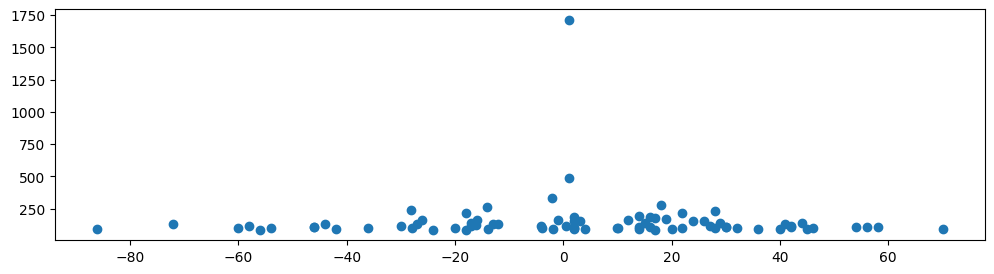

In [71]:
hplot(new[1:], 80)

In [73]:
for ii in range(len(orbi_datasets)):
    write_top_histo_bins(orbi_datasets[ii], 
                         collection_deltas[ii],
                         )

In [92]:
# do KDE
for ii in range(len(orbi_datasets)):
    peaks_density = get_kde_per_dataset(
        collection_deltas[ii], bandwidth=0.0005, threshold=0.001, topN=500
    )
    write_top_kde_peaks(orbi_datasets[ii], peaks_density)

**Note**

Tricky to optimize KDE peak finding parameters for noisier data. When overall density is low, peak shapes are not clear.

Histogram is robust to use here.

In [95]:
def get_histogram_fixed_bins(list_kp_deltas, bins):
    '''
    Returns histogram on fixed bins using abs values
    '''
    list_deltas = []
    for v in list_kp_deltas:
        list_deltas += v[1]
    list_deltas = abs(np.array(list_deltas))
    return np.histogram(list_deltas, bins)[0]

In [97]:
fixed_bins = np.arange(0.1, 310, 0.0001)
cummulative_histo = np.zeros(len(fixed_bins)-1)

for d in collection_deltas:
    cummulative_histo += get_histogram_fixed_bins(d, fixed_bins)

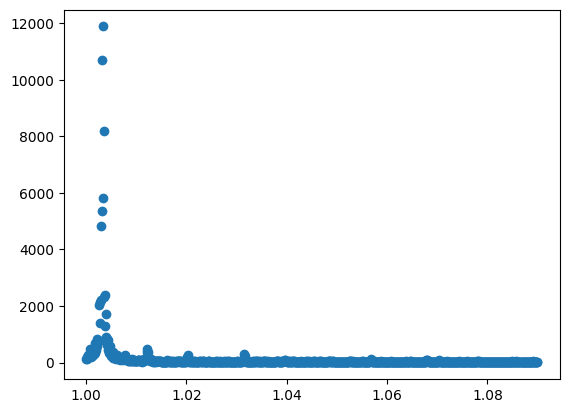

In [112]:
plt.plot(fixed_bins[9000: 9900], cummulative_histo[9000: 9900], 'o')

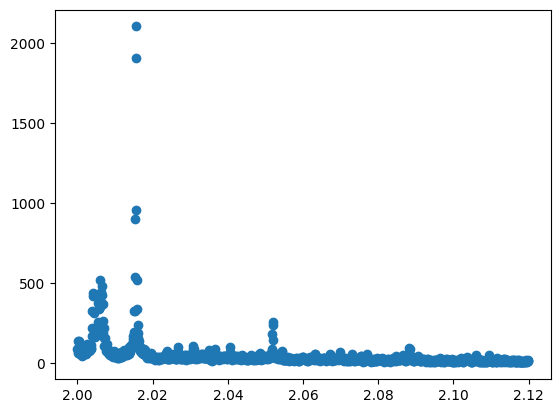

In [114]:
plt.plot(fixed_bins[19000: 20200], cummulative_histo[19000: 20200], 'o')

In [115]:
peaks_density = uniform_filter1d(cummulative_histo, 5, mode='nearest')
peaks_density = get_kde_peaks(fixed_bins[:-1], peaks_density, height=100)
peaks_density = sorted(peaks_density, key=lambda x: x[1], reverse=True)

In [118]:
len(peaks_density), peaks_density[:20]

(459,
 [(1.0033000000000258, 7399.24),
  (14.015500000000399, 1397.3999999999992),
  (2.0156000000000547, 1145.1199999999992),
  (18.010400000000516, 1099.12),
  (67.98730000000194, 1030.5600000000009),
  (44.02610000000126, 865.2000000000007),
  (21.98180000000063, 859.5199999999999),
  (28.0312000000008, 849.9200000000003),
  (15.994800000000454, 791.9599999999996),
  (11.999900000000341, 705.5199999999991),
  (26.015500000000745, 702.9599999999999),
  (27.9948000000008, 652.9600000000003),
  (30.010400000000857, 635.9600000000003),
  (46.00530000000131, 571.4400000000005),
  (1.9969000000000545, 564.4799999999992),
  (82.00290000000234, 524.1600000000009),
  (42.010400000001205, 522.7600000000006),
  (23.999900000000686, 519.8399999999999),
  (43.98970000000126, 513.6800000000006),
  (13.979100000000397, 511.87999999999937)])

In [119]:
s = 'delta_mz\tcount_estimate\n'
for x in peaks_density:
    s += str(round(x[0], 4)) + '\t' + str(int(x[1])) + '\n'
with open('top_frequent_delta_mz_orbi-20241114.tsv', 'w') as O:
    O.write(s)

In [122]:
from mass2chem.lib.common_mass import mass_signatures

def search_mass_signatures(m, mass_signatures=mass_signatures):
    _d = [abs(m-abs(x[0])) for x in mass_signatures]
    _ii = np.argmin(_d)
    if _d[_ii] < 0.005:
        return mass_signatures[_ii], _d[_ii]
    else:
        return None

In [123]:
search_mass_signatures(28.0312)

((28.0313,
  '± C2H4, natural alkane chains such as fatty acids',
  {'C': 2, 'H': 4}),
 0.00010000000000331966)

In [125]:
s = 'delta_mz\tcount_estimate\tmass_signature\tnote\tdict\n'
for x in peaks_density:
    _M = search_mass_signatures(x[0])
    if _M:
        s += str(round(x[0], 4)) + '\t' + str(int(x[1])) + '\t' + '\t'.join(
            [str(ii) for ii in _M[0] ]) + '\n'
    else:
        s += str(round(x[0], 4)) + '\t' + str(int(x[1])) + '\n'
        
with open('top_frequent_delta_mz_orbi_anno-20241114.tsv', 'w') as O:
    O.write(s)

### Do pos and neg ions separately

In [126]:
fixed_bins = np.arange(0.1, 500.01, 0.0001)
cummulative_histo_pos = np.zeros(len(fixed_bins)-1)
cummulative_histo_neg = np.zeros(len(fixed_bins)-1)

for ii in range(len(collection_deltas)):
    if 'pos' in orbi_datasets[ii]:
        cummulative_histo_pos += get_histogram_fixed_bins(collection_deltas[ii], fixed_bins)
    elif 'neg' in orbi_datasets[ii]:
        cummulative_histo_neg += get_histogram_fixed_bins(collection_deltas[ii], fixed_bins)
    else:
        print("Error, ", orbi_datasets[ii])

In [133]:
curated_msig = []
for line in open('top_frequent_delta_mz_orbi_anno-20241114b.tsv').readlines()[1:]:
    a = line.rstrip().replace('\t', '    ').split('    ')
    if len(a) > 2:
        curated_msig.append((
            float(a[0]), a[2:]
        ))

In [130]:
search_mass_signatures(2.0156, curated_msig)

((2.0156, ['2.01565', '± 2H, opening or forming of double bond', "{'H': 2}"]),
 0.0)

In [134]:
# pos
peaks_density = uniform_filter1d(cummulative_histo_pos, 5, mode='nearest')
peaks_density = get_kde_peaks(fixed_bins[:-1], peaks_density, height=100)
peaks_density = sorted(peaks_density, key=lambda x: x[1], reverse=True)

s = 'delta_mz\tcount_estimate\tmass_signature\tnote\tdict\n'
for x in peaks_density:
    _M = search_mass_signatures(x[0], curated_msig)
    if _M:
        s += str(round(x[0], 4)) + '\t' + str(int(x[1])) + '\t' + '\t'.join(
            [str(ii) for ii in _M[0] ]) + '\n'
    else:
        s += str(round(x[0], 4)) + '\t' + str(int(x[1])) + '\n'
    
with open('top_frequent_delta_mz_orbi_pos-20241116.tsv', 'w') as O:
    O.write(s)

In [135]:
# neg
peaks_density = uniform_filter1d(cummulative_histo_neg, 5, mode='nearest')
peaks_density = get_kde_peaks(fixed_bins[:-1], peaks_density, height=100)
peaks_density = sorted(peaks_density, key=lambda x: x[1], reverse=True)

s = 'delta_mz\tcount_estimate\tmass_signature\tnote\tdict\n'
for x in peaks_density:
    _M = search_mass_signatures(x[0], curated_msig)
    if _M:
        s += str(round(x[0], 4)) + '\t' + str(int(x[1])) + '\t' + '\t'.join(
            [str(ii) for ii in _M[0] ]) + '\n'
    else:
        s += str(round(x[0], 4)) + '\t' + str(int(x[1])) + '\n'  
    
with open('top_frequent_delta_mz_orbi_neg-20241116.tsv', 'w') as O:
    O.write(s)

## Conclusion

We have calculated most frequent mz deltas in Orbitrap datasets.

Rough annotation is drawn from mass2chem etc. 

Will reformat the tables and update with full annotation.